53565.87064457103
1098.6578534427238
-0.00025444331827797513
-1.457113808637619e-05
-0.16168426720430218
0.08751022927070379
0.5799556116222258


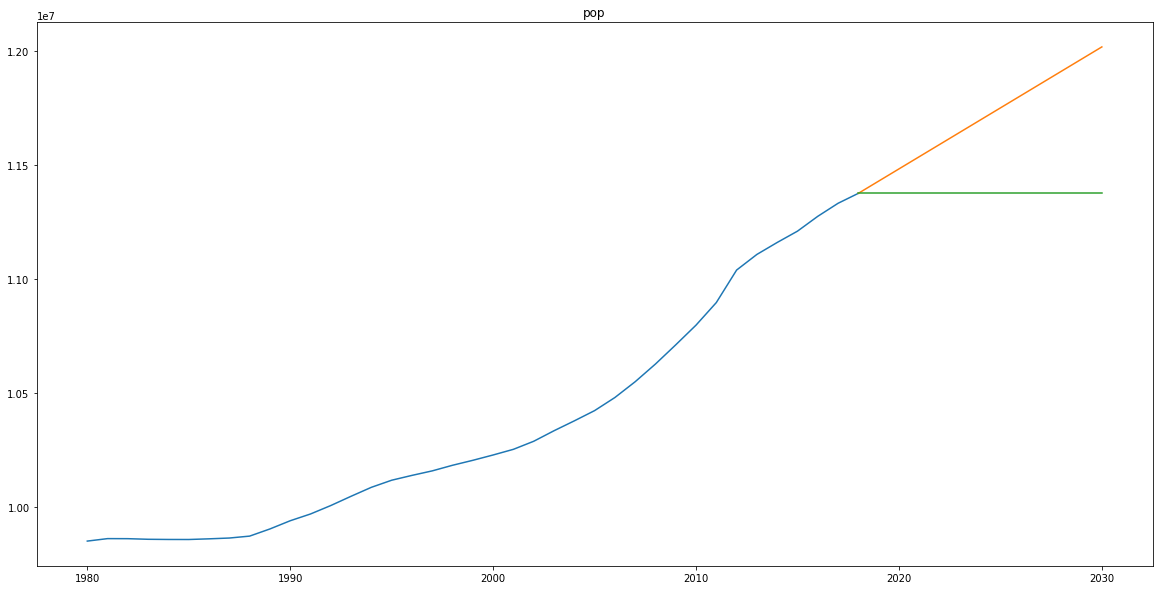

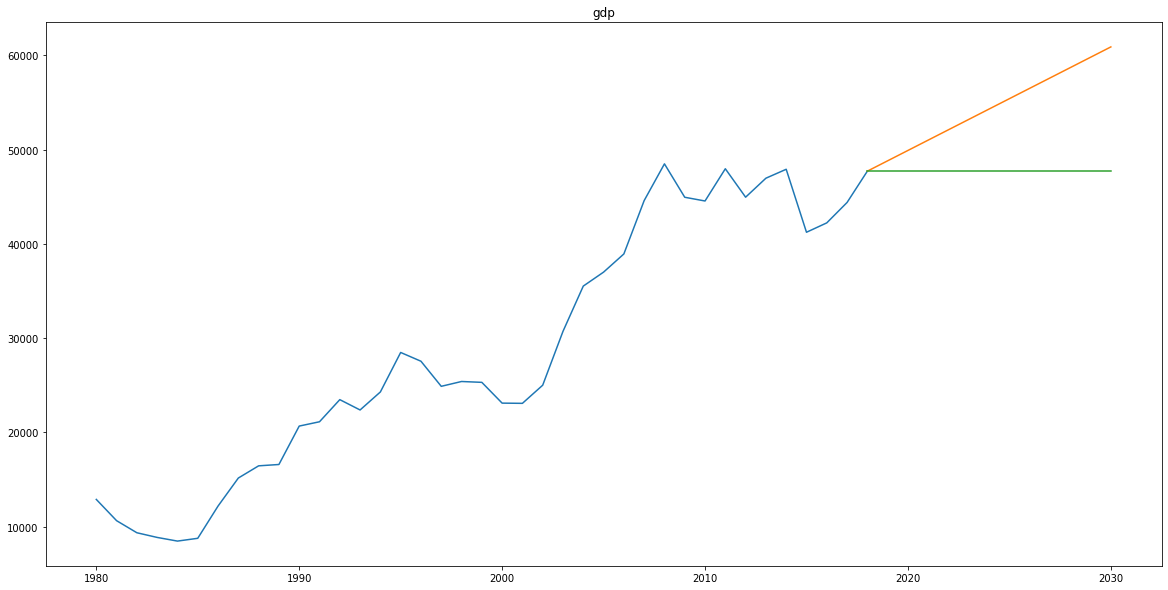

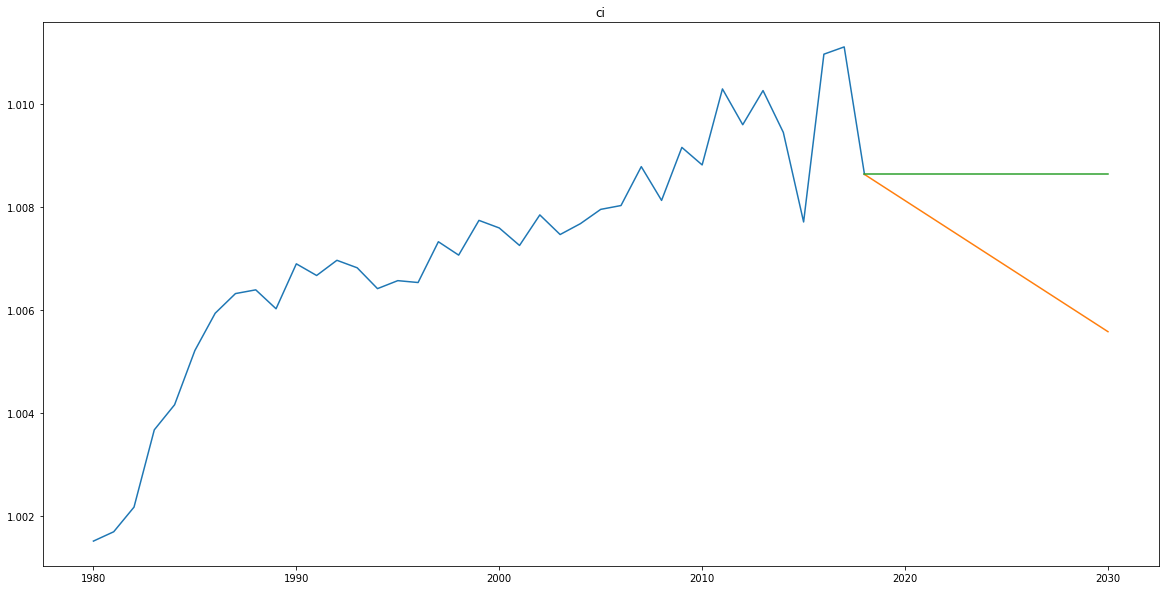

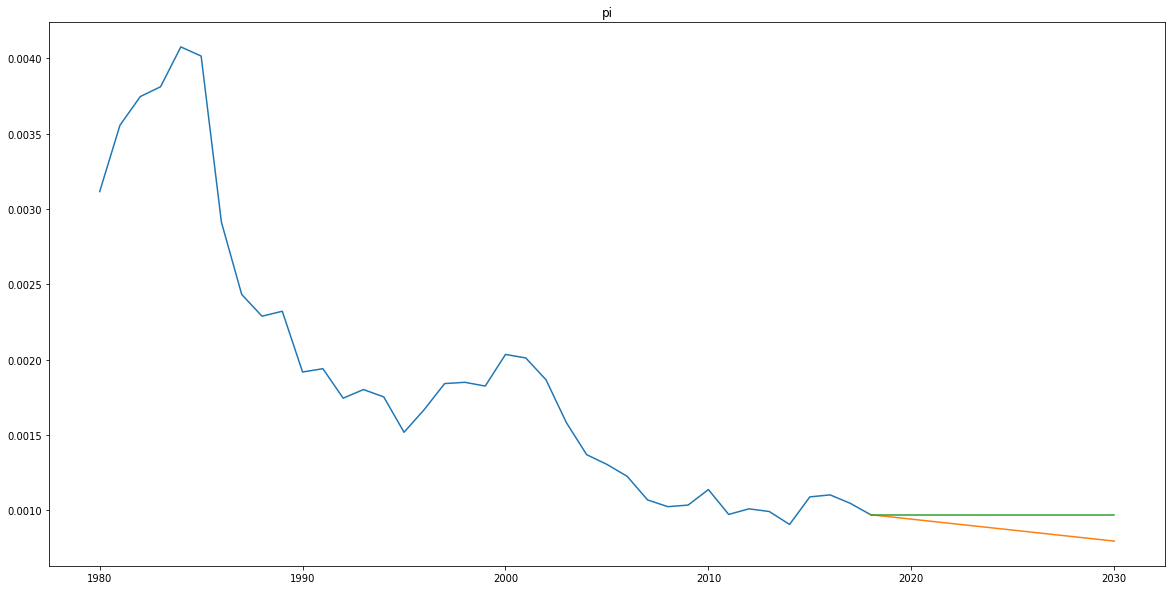

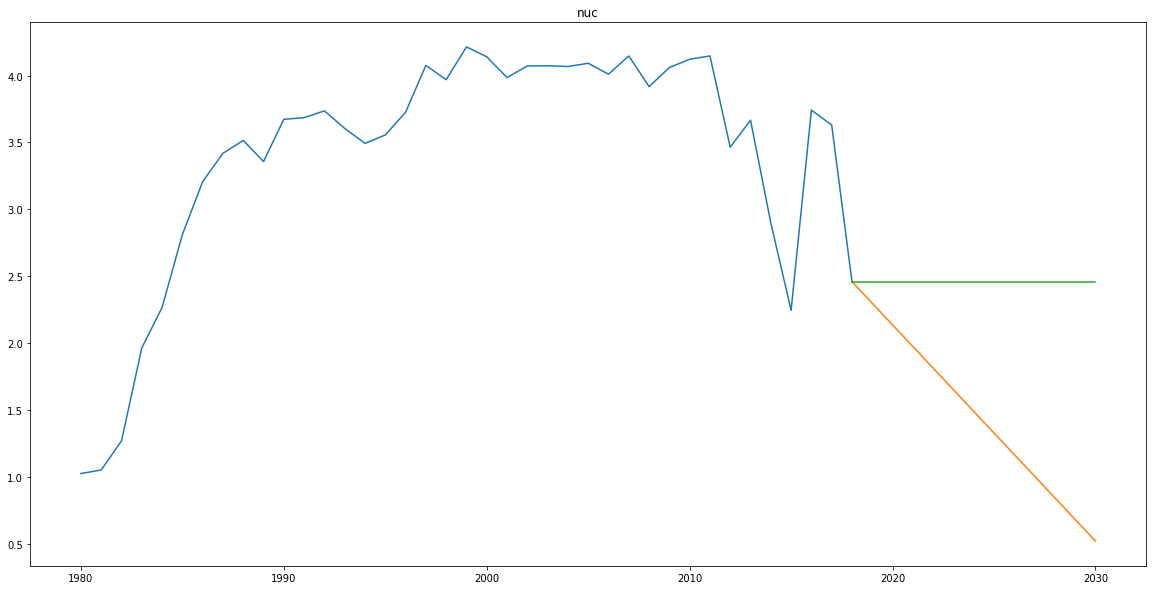

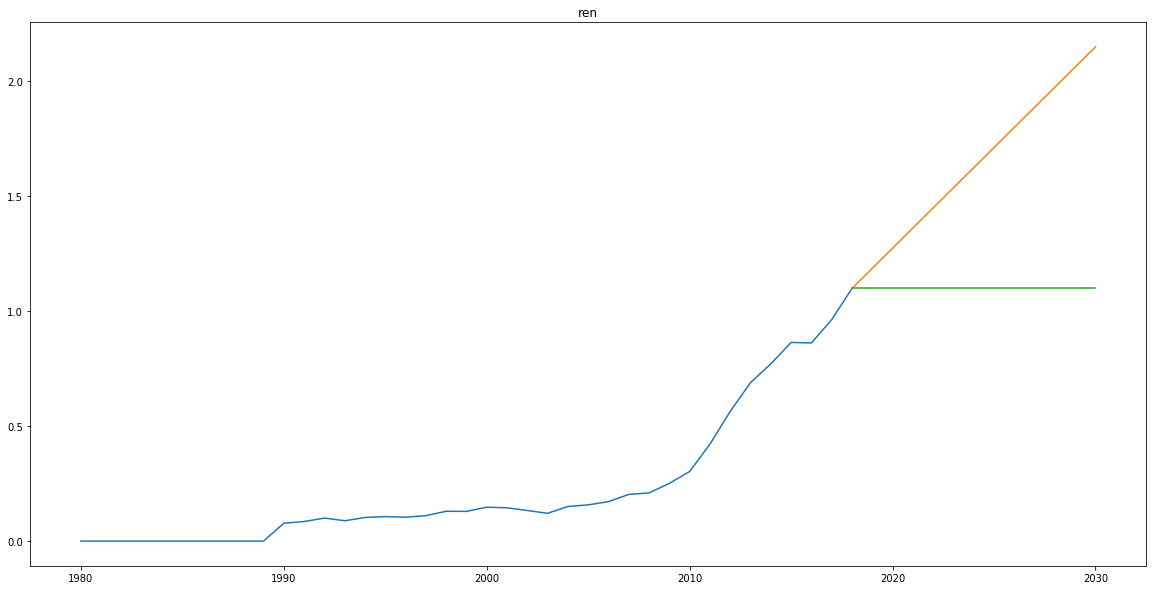

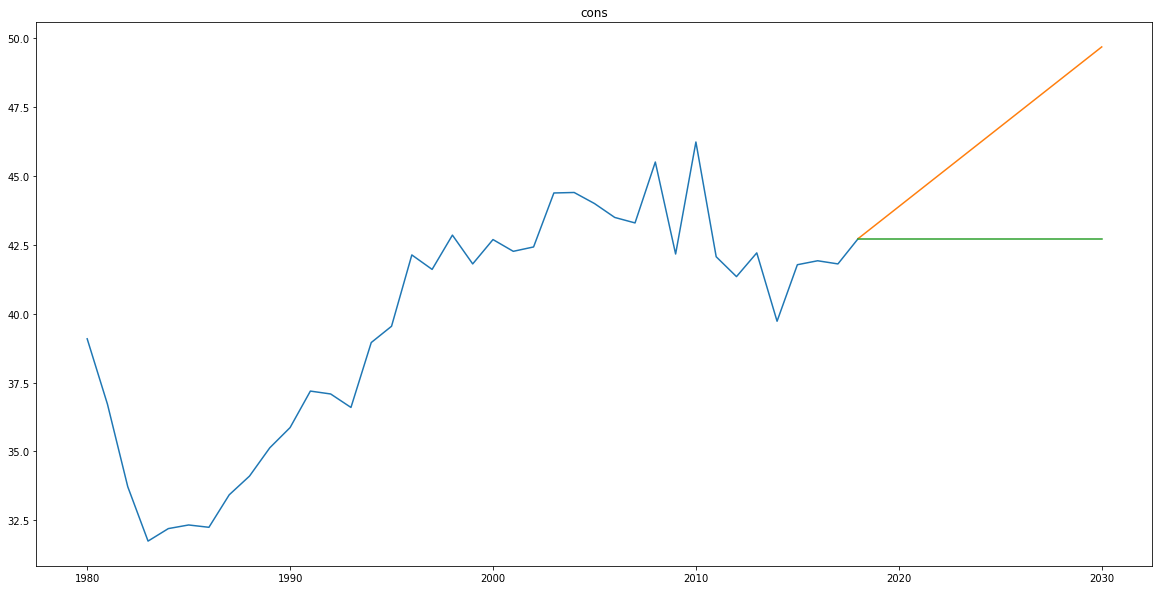

In [97]:
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interact_manual


from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
# behavior of explicative data during last years

file_name = 'belgium_information.csv' 
bel_info = pd.read_csv(file_name)
bel_info.set_axis(['years', 'pop', 'gdp', 'ci', 'pi', 'nuc', 'ren', 'cons'], axis=1, inplace=True)

def modf(x, a, b):
    return (a*x)+b

x = bel_info['years'][-5:]
x_sc = np.arange(2018, 2031)
sigma = np.ones(len(x))
sigma[[-1]] = 0.01

#scenario statut quo
df_sc_sq = pd.DataFrame(x_sc)
df_sc_cst = pd.DataFrame(x_sc)
df_sc_down = pd.DataFrame(x_sc)

for column in bel_info:
    if column != 'years':

        y = bel_info[column][-5:]
        popt, pcov = curve_fit(modf, x, y, sigma=sigma)
        print(popt[1])
        df_sc_sq['{}'.format(column)] = modf(x_sc, popt[0], popt[1])
        df_sc_cst['{}'.format(column)] = y.loc[38]

        fig, ax = plt.subplots(figsize=(20,10))
        ax.plot(bel_info['years'], bel_info[column])
        ax.plot(x_sc, modf(x_sc, popt[0], popt[1]))
        ax.plot(x_sc, df_sc_cst[column])
        ax.set_title(column)


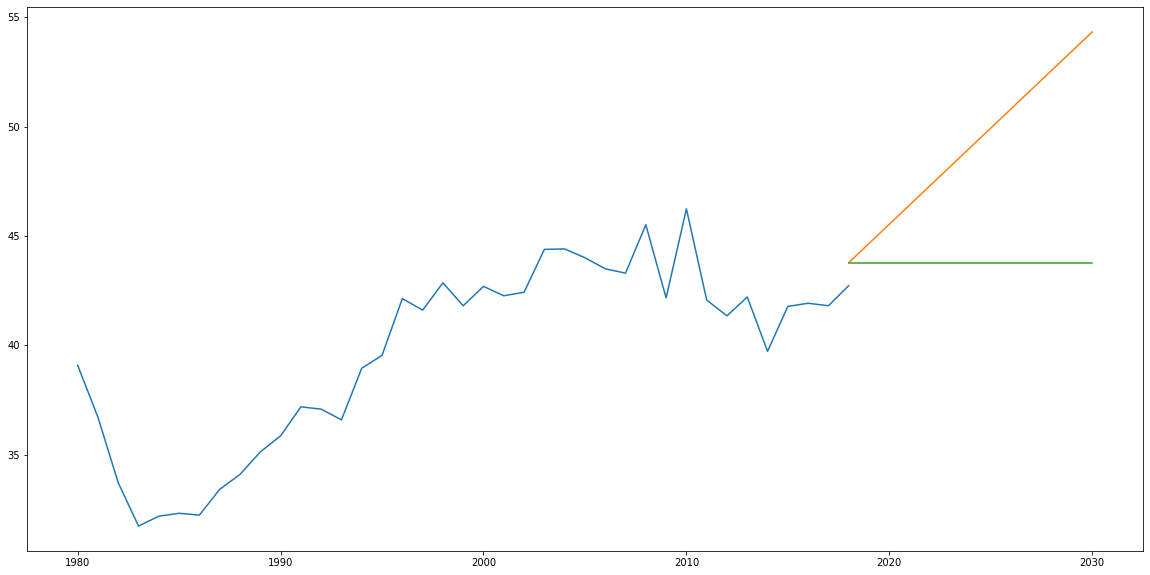

In [23]:


# Create linear regression object.
mlr= LinearRegression()

data = bel_info.to_numpy()

x_train = data[:,1:7]
y_train = data[:,7:8]
# Fit linear regression.
mlr.fit(x_train, y_train)

frcst_sq = df_sc_sq.drop(columns=[0, 'cons']).to_numpy()
y_pred_sq = mlr.predict(frcst_sq)

frcst_cst = df_sc_cst.drop(columns=[0, 'cons']).to_numpy()
y_pred_cst = mlr.predict(frcst_cst)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(bel_info['years'], bel_info['cons'])
ax.plot(x_sc, y_pred_sq)
ax.plot(x_sc, y_pred_cst)


In [116]:
def line_frcst(x, y, x_sc):
    def modf(x, a, b):
        return (a*x)+b
    
    sigma = np.ones(len(x))
    sigma[[-1]] = 0.01
    popt, pcov = curve_fit(modf, x, y, sigma=sigma)
    
    return popt[0]*x_sc + popt[1]

@interact
def interactive(pop=(0, 1), gdp=(0, 1), ci=(0, 1), pi=(0, 1), nuc=(0, 1), ren=(0, 1)):
    df_frcst = pd.DataFrame(x_sc)
    
    #
    df_frcst['pop'] = np.select(
    [
        pop == 0,
        pop == 1
    ],
    [
        line_frcst(bel_info['years'][-5:], bel_info['pop'][-5:], x_sc),
        bel_info['pop'].loc[38]
    ])
    
    #
    df_frcst['gdp'] = np.select(
    [
        gdp == 0,
        gdp == 1
    ],
    [
        line_frcst(bel_info['years'][-5:], bel_info['gdp'][-5:], x_sc),
        bel_info['gdp'].loc[38]
    ])
        
    #
    df_frcst['ci'] = np.select(
    [
        ci == 0,
        ci == 1
    ],
    [
        line_frcst(bel_info['years'][-5:], bel_info['ci'][-5:], x_sc),
        bel_info['ci'].loc[38]
    ])
    
    #
    df_frcst['pi'] = np.select(
    [
        pi == 0,
        pi == 1
    ],
    [
        line_frcst(bel_info['years'][-5:], bel_info['pi'][-5:], x_sc),
        bel_info['pi'].loc[38]
    ])
    
    #
    df_frcst['nuc'] = np.select(
    [
        nuc == 0,
        nuc == 1
    ],
    [
        line_frcst(bel_info['years'][-5:], bel_info['nuc'][-5:], x_sc),
        bel_info['nuc'].loc[38]
    ])
    
    #
    df_frcst['ren'] = np.select(
    [
        ren == 0,
        ren == 1
    ],
    [
        line_frcst(bel_info['years'][-5:], bel_info['ren'][-5:], x_sc),
        bel_info['ren'].loc[38]
    ])
    
    df_frcst.drop(columns=[0], inplace=True)
    y_pred = mlr.predict(df_frcst.to_numpy())
    print(mlr.intercept_) 
    print(mlr.coef_)
    
    y_pred[0] = bel_info['cons'][-1:]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(bel_info['years'], bel_info['cons'])
    ax.plot(x_sc, y_pred)
    
    ax.set_xlabel('Years')
    ax.set_ylabel('Consomation of primary energy [Mtoe]')
    ax.grid(axis='y')
    ax.set_ylim(ymin= 30, ymax = 60)

interactive(children=(IntSlider(value=0, description='pop', max=1), IntSlider(value=0, description='gdp', max=…

In [120]:
from sklearn.linear_model import BayesianRidge
blr= BayesianRidge(tol=1e-6, n_iter=1000,  lambda_1=550000, compute_score=True)

x_train = data[:,1:7]
y_train = data[:,7:8]

y_train = np.ravel(y_train)
# Fit linear regression.
blr.fit(x_train, y_train)


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=True, lambda_1=550000, lambda_2=1e-06, n_iter=1000,
              normalize=False, tol=1e-06, verbose=False)

In [121]:

def fossil_consumption(fmodel):
    @interact
    def interactive(pop=(0.000, 0.005, 0.0025), gdp=(-0.02, 0.02, 0.02), ci=(-0.0002, 0.0002, 0.0002),
                    pi=(-0.002, 0.002, 0.002), nuc=(-0.1, 0.1, 0.1), ren=(-0.1, 0.1, 0.1)):
        df_frcst = pd.DataFrame(x_sc)
        frcst_inter = np.arange(x_sc.shape[0])
        
        for column in bel_info:
            if column != 'years':
                df_frcst['{}'.format(column)] = bel_info[column][38]
        
        df_frcst['pop'] += pop*df_frcst['pop']*frcst_inter
        df_frcst['gdp'] += gdp*df_frcst['gdp']*frcst_inter
        df_frcst['ci'] += ci*df_frcst['ci']*frcst_inter
        df_frcst['pi'] += pi*df_frcst['pi']*frcst_inter
        df_frcst['nuc'] += nuc*df_frcst['nuc']*frcst_inter
        df_frcst['ren'] += ren*df_frcst['ren']*frcst_inter

        df_frcst[df_frcst < 0] = 0
        df_frcst.drop(columns=[0, 'cons'], inplace=True)

        y_pred = fmodel.predict(df_frcst.to_numpy())
        y_pred[y_pred < 0] = 0
        y_pred[0] = bel_info['cons'][-1:]
        
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(bel_info['years'], bel_info['cons'])
        ax.plot(x_sc, y_pred)

        ax.set_xlabel('Years')
        ax.set_ylabel('Consomation of primary energy [Mtoe]')
        ax.grid(axis='y')
        ax.set_ylim(ymin= 30, ymax = 60)
        
fossil_consumption(mlr)
fossil_consumption(blr)

interactive(children=(FloatSlider(value=0.0025, description='pop', max=0.005, step=0.0025), FloatSlider(value=…

interactive(children=(FloatSlider(value=0.0025, description='pop', max=0.005, step=0.0025), FloatSlider(value=…

0.0
